In [129]:
# # get data
# import os
# DIFFUSIONDB_IMGS_PATH = "/mnt/d/AiStuff/data/diffusionDB2M"
# PART1_IMGS = "diffusiondb-2m-part-0001-to-0100-of-2000"
# PART1_IMGS_PATH = os.path.join(DIFFUSIONDB_IMGS_PATH, PART1_IMGS)

# #csv
# import pandas as pd
# df = pd.read_parquet("../../datasets/diffusiondb2m/metadata.parquet")
# df.head()

In [130]:
# get data
import os
PART1_IMGS_PATH = "../datasets/sampleeval"

#csv
import pandas as pd
df = pd.read_csv("../datasets/sampleeval/prompts.csv")
df

imgId                                             prompt
0  20057f34d  hyper realistic photo of very friendly and dys...
1  227ef0887  ramen carved out of fractal rose ebony, in the...
2  92e911621  ultrasaurus holding a black bean taco in the w...
3  a4e1c55a9  a thundering retro robot crane inks on parchme...
4  c98f79f71  portrait painting of a shimmering greek hero, ...
5  d8edf2e40  an astronaut standing on a engaging white rose...
6  f27825b2c  Kaggle employee Phil at a donut shop ordering ...

In [131]:
img_paths = [os.path.join(PART1_IMGS_PATH, df.iloc[idx]['imgId']+".png") for idx in range(len(df))]
img_paths

['../datasets/sampleeval/20057f34d.png',
 '../datasets/sampleeval/227ef0887.png',
 '../datasets/sampleeval/92e911621.png',
 '../datasets/sampleeval/a4e1c55a9.png',
 '../datasets/sampleeval/c98f79f71.png',
 '../datasets/sampleeval/d8edf2e40.png',
 '../datasets/sampleeval/f27825b2c.png']

In [132]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [133]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    colors = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        colors.append(color_mask)
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))
    
    return colors

# ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
def show_box_anns(anns, top_k=None, colors=None, crop_captions:list=None):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    
    ax = plt.gca()
    ax.set_autoscale_on(False)
    
    c = 0

    for ann in sorted_anns:
        box = ann['bbox']
        x0, y0 = box[0], box[1]
        # w,h = box[2] - box[0], box[3] - box[1]
        w,h = box[2], box[3]
        if colors is None:
            color_mask = np.random.random((1, 3)).tolist()[0]
        else:
            color_mask = colors[c]
        ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=color_mask, facecolor=(0,0,0,0), lw=2))
        if crop_captions is not None:
            ax.text(x0, y0, crop_captions[c], bbox=dict(facecolor=color_mask, alpha=0.5))
        
        c += 1
        if c == top_k:
            break


In [134]:
# # idx = 1
# # image = cv2.imread(os.path.join(PART1_IMGS_PATH, df.iloc[idx]['image_name'].replace(".png", ".jpg")))
# # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # plt.figure(figsize=(5,5))
# # plt.imshow(image)
# # plt.figtext(0.5, 0.01, df.iloc[idx]['prompt'], wrap=True, horizontalalignment='center', fontsize=12)
# # plt.axis('off')
# # plt.show()

# idx = 6
# image = cv2.imread(os.path.join(PART1_IMGS_PATH, df.iloc[idx]['imgId']+".png"))
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plt.figure(figsize=(5,5))
# plt.imshow(image)
# plt.figtext(0.5, 0.01, df.iloc[idx]['prompt'], wrap=True, horizontalalignment='center', fontsize=12)
# plt.axis('off')
# plt.show()

In [135]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import time

sam_checkpoint = "../models/sam_vit_h_4b8939.pth"
model_type = "vit_h"
# sam_checkpoint = "../models/sam_vit_b_01ec64.pth"
# model_type = "vit_b"

device = "cuda"

start_time = time.time()

# sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.half()
sam.eval()
sam.requires_grad_(False)
sam.to(device='cuda')

mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=16,
        pred_iou_thresh=0.9,
        stability_score_thresh=0.95,
    )

print(f"{(time.time() - start_time)} seconds to load")
# half - 5.916656732559204 seconds to load
    # cpu - 15.67760705947876 seconds to load
# full - 5.497025012969971 seconds to load
    # cpu - cannot load

6.942892074584961 seconds to load


In [136]:
def sam_image_crops(image, mask_generator, top_n_bbox, h_w_ratio=2.5):
    masks = mask_generator.generate(image)
    sorted_anns = sorted(masks, key=(lambda x: x['predicted_iou']), reverse=True)
    
    crops = []
    filtered_anns = []
    for ann in sorted_anns:
        x0, y0, width, height = ann['bbox']

        # print(crop.shape)
        ratio = height/(width+1e-6)
        if width > height:
            ratio = width/(height+1e-6)
            
        if height < 10 or width < 10:
            continue
            
        if ratio > h_w_ratio: # throw out images that are too thin, they don't provide much info
            continue

        crops.append(image[y0:y0+height, x0:x0+width, :])
        filtered_anns.append(ann)
        if len(crops) >= top_n_bbox:
            break
        
    return crops, filtered_anns

In [137]:
from torch.cuda.amp import autocast

# os.path.join(PART1_IMGS_PATH, df.iloc[idx]['imgId']+".png")
sam_crops = []
for image_id in df['imgId'].values:
    image = cv2.imread(os.path.join(PART1_IMGS_PATH, f"{image_id}.png"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    with autocast(dtype=torch.float16):
        crops, filtered_anns = sam_image_crops(image, mask_generator, 4)
        sam_crops.append({"crops":crops, "filtered_anns":filtered_anns})
    
print([len(sam_crop["crops"]) for sam_crop in sam_crops])
print([len(sam_crop["filtered_anns"]) for sam_crop in sam_crops])

print(sam_crops[0]["filtered_anns"][0].keys())

[4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4]
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


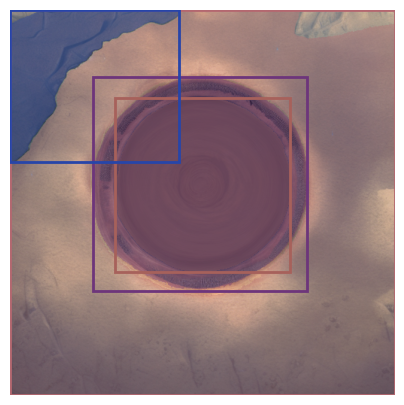

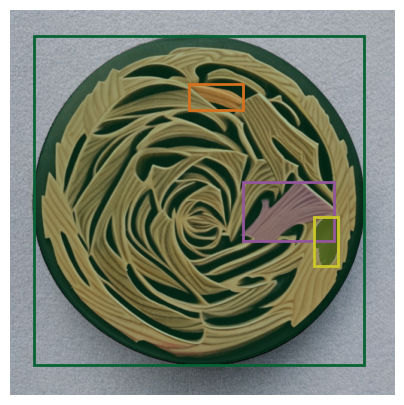

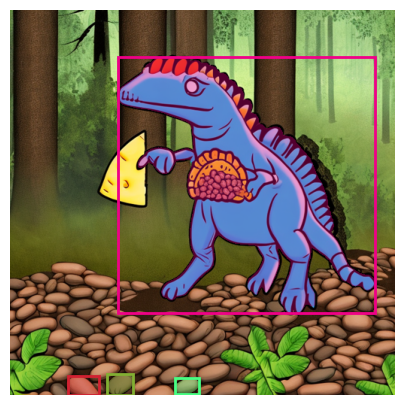

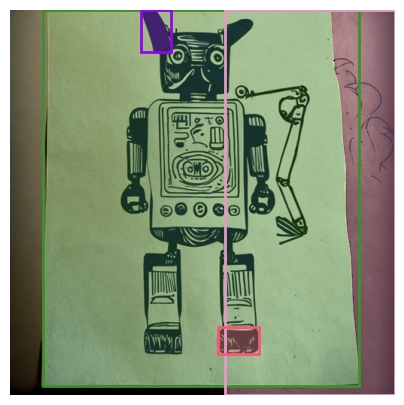

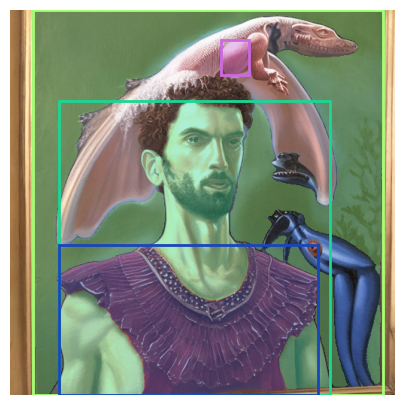

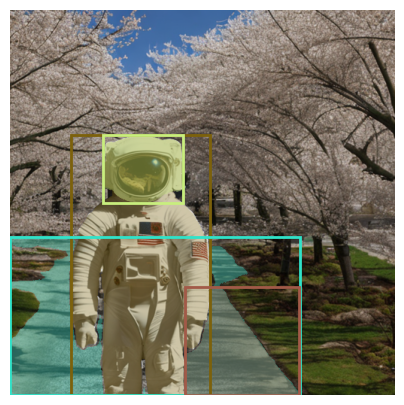

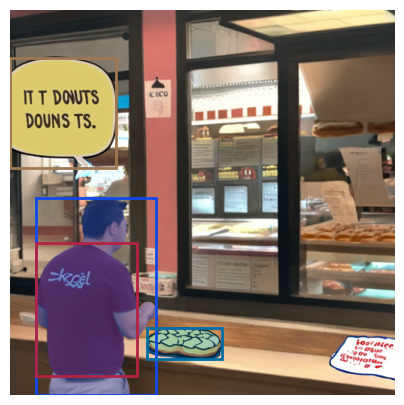

In [138]:
for image_id, sam_crop in zip(df['imgId'].values, sam_crops):
    image = cv2.imread(os.path.join(PART1_IMGS_PATH, f"{image_id}.png"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    # show_anns(filtered_anns)
    filtered_anns = sam_crop["filtered_anns"]
    colors = show_anns(filtered_anns)
    show_box_anns(filtered_anns, colors=colors)
    plt.axis('off')
    
plt.show()

# BLIP Caption

In [142]:
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to("cuda")

# unconditional image captioning
from PIL import Image

def generate_caption_blip(image: Image):
    # image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to("cuda")
    out = model.generate(**inputs)
    return processor.decode(out[0], skip_special_tokens=True, max_length=40)

image = Image.open(os.path.join(PART1_IMGS_PATH, f"2.png")).convert("RGB")
generate_caption_blip(image)

'there is a cat that is playing with a ball on the grass'

In [144]:
# GIT BASE

from transformers import AutoProcessor, AutoModelForCausalLM

processor = AutoProcessor.from_pretrained("microsoft/git-base")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

from PIL import Image

def generate_caption(image: Image):
    # image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    outputs = model.generate(**inputs)
    return processor.decode(outputs[0], skip_special_tokens=True, max_length=40)

for img_path in img_paths:
    image = Image.open(img_path).convert("RGB")
    print(generate_caption(image))
# image = Image.open(os.path.join(PART1_IMGS_PATH, f"2.png")).convert("RGB")
# generate_caption(image)

/home/jimmyyao/miniconda3/envs/rev-sd2/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a circle in the middle of the earth
a black wall
dinosaur eating a piece of cheese
a drawing of a robot
a painting of a man with a dragon
a man in an astronaut suit
a man wearing a blue shirt


3


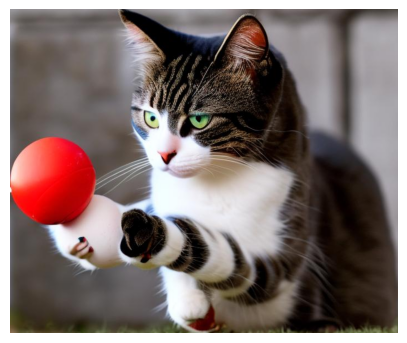

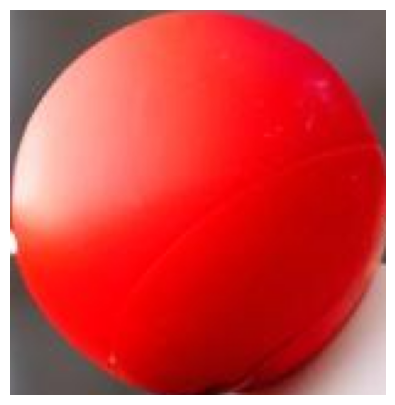

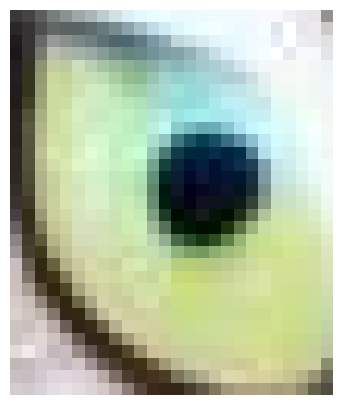

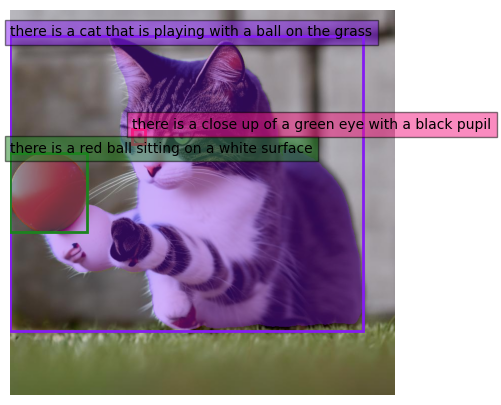

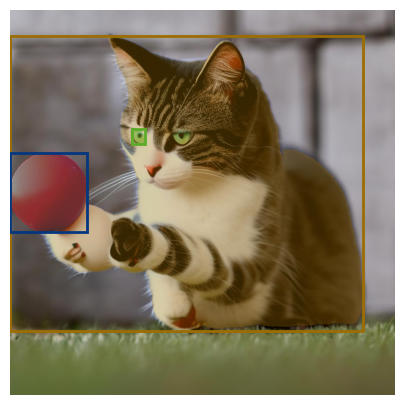

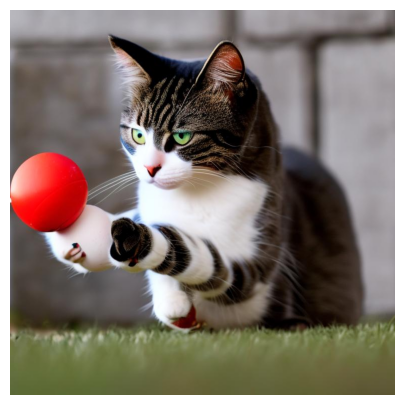

In [140]:
# test cat

image = cv2.imread(os.path.join(PART1_IMGS_PATH, f"2.png"))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
with autocast(dtype=torch.float16):
    crops, filtered_anns = sam_image_crops(image, mask_generator, 3, h_w_ratio=3)

    print(len(filtered_anns))
    
    crop_captions = []
    for crop in crops:
        crop = Image.fromarray(crop)
        crop_captions.append(generate_caption_blip(crop))
        plt.figure(figsize=(5,5))
        plt.imshow(crop)
        plt.axis('off')

plt.figure(figsize=(5,5))
plt.imshow(image)
colors = show_anns(filtered_anns)
show_box_anns(filtered_anns, colors=colors, crop_captions=crop_captions)
plt.axis('off')

plt.figure(figsize=(5,5))
plt.imshow(image)
colors = show_anns(filtered_anns)
show_box_anns(filtered_anns, colors=colors)
plt.axis('off')

plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

# for image_id, sam_crop in zip(df['imgId'].values, sam_crops):
#     image = cv2.imread(os.path.join(PART1_IMGS_PATH, f"{image_id}.png"))
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
#     plt.figure(figsize=(5,5))
#     plt.imshow(image)
#     # show_anns(filtered_anns)
#     filtered_anns = sam_crop["filtered_anns"]
#     crop_captions = sam_crop["crop_captions"]
#     colors = show_anns(filtered_anns)
#     show_box_anns(filtered_anns, colors=colors, crop_captions=crop_captions)
#     # 
#     plt.axis('off')
#     plt.savefig(f"pltimg/{image_id}.png", bbox_inches='tight', pad_inches=0)
    
# plt.show()

# for sam_crop in sam_crops:
#     crops = sam_crop["crops"]
#     filtered_anns = sam_crop["filtered_anns"]
#     crop_captions = sam_crop["crop_captions"]
    
#     for crop, crop_caption in zip(crops, crop_captions):
#         plt.figure(figsize=(5,5))
#         plt.imshow(crop)
#         print(crop_caption)

In [86]:
def caption_img_sam(sam_crops: list) -> str:
    for i, sam_crop in enumerate(sam_crops):
        crops = sam_crop["crops"]
        # filtered_anns = sam_crop["filtered_anns"]
        crop_captions = []
        
        for crop in crops:
            crop = Image.fromarray(crop)
            # caption = generate_caption_blip(crop)
            crop_captions.append(generate_caption_blip(crop))
        sam_crops[i]["crop_captions"] = crop_captions
        
caption_img_sam(sam_crops)

(-0.5, 511.5, 511.5, -0.5)

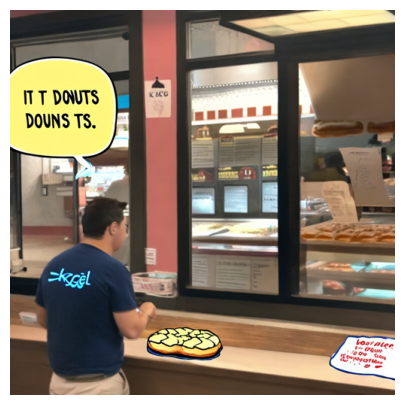

In [87]:
plt.figure(figsize=(5,5))
plt.imshow(Image.open(img_paths[-1]).convert("RGB"))
plt.axis('off')

there is a man that is cutting his hair with a scissors
there is a man standing at a counter with a pizza


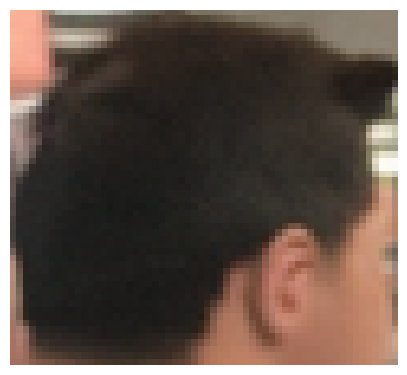

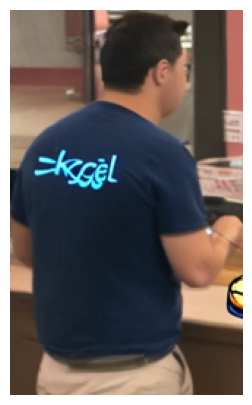

In [88]:
for sam_crop in sam_crops[-1:]:
    crops = sam_crop["crops"]
    filtered_anns = sam_crop["filtered_anns"]
    crop_captions = sam_crop["crop_captions"]
    
    for crop, crop_caption in zip(crops, crop_captions):
        plt.figure(figsize=(5,5))
        plt.imshow(crop)
        plt.axis('off')
        print(crop_caption)

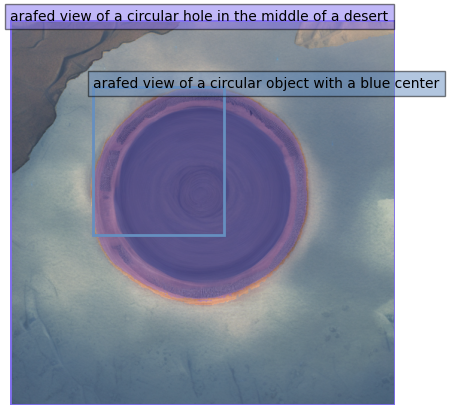

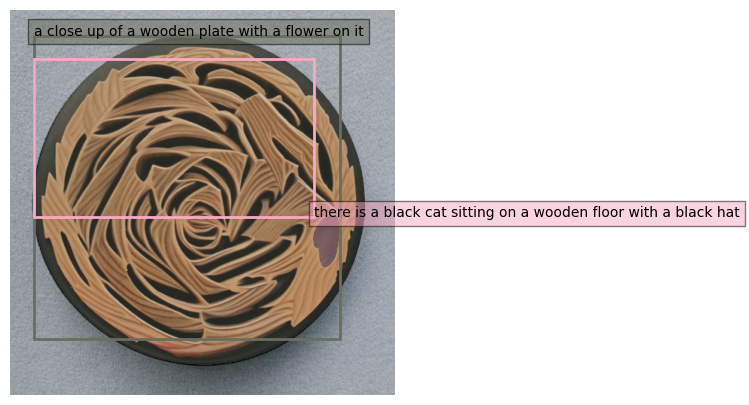

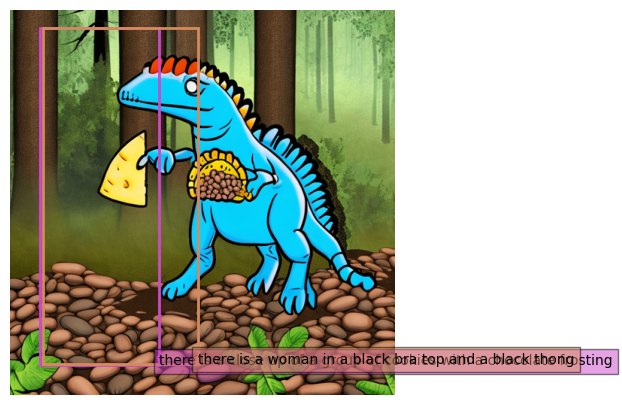

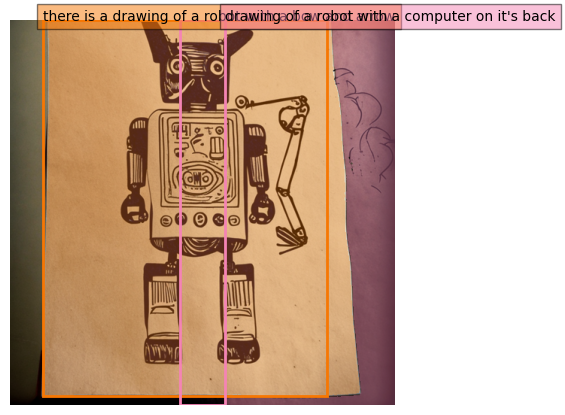

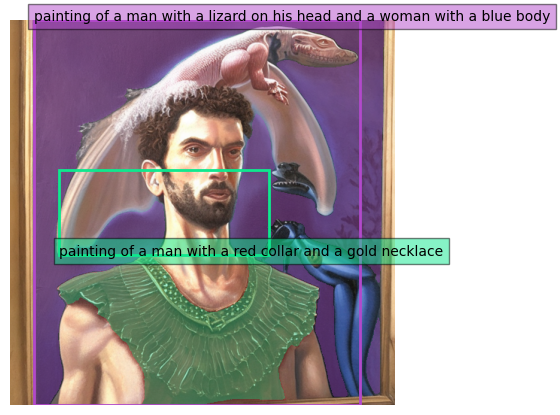

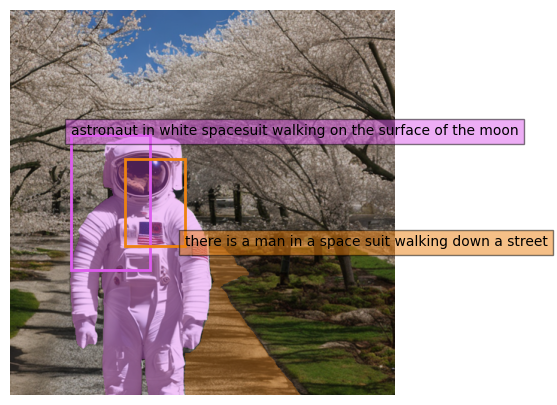

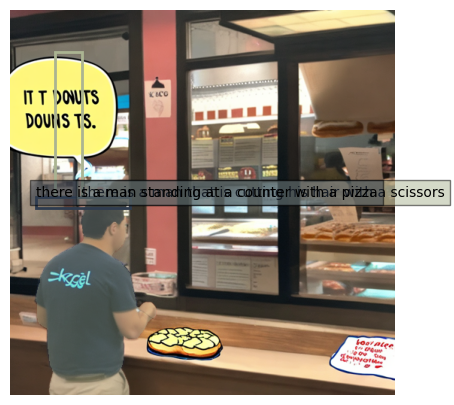

In [89]:
for image_id, sam_crop in zip(df['imgId'].values, sam_crops):
    image = cv2.imread(os.path.join(PART1_IMGS_PATH, f"{image_id}.png"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    # show_anns(filtered_anns)
    filtered_anns = sam_crop["filtered_anns"]
    crop_captions = sam_crop["crop_captions"]
    colors = show_anns(filtered_anns)
    show_box_anns(filtered_anns, colors=colors, crop_captions=crop_captions)
    # 
    plt.axis('off')
    plt.savefig(f"pltimg/{image_id}.png", bbox_inches='tight', pad_inches=0)
    
plt.show()

# for sam_crop in sam_crops:
#     crops = sam_crop["crops"]
#     filtered_anns = sam_crop["filtered_anns"]
#     crop_captions = sam_crop["crop_captions"]
    
#     for crop, crop_caption in zip(crops, crop_captions):
#         plt.figure(figsize=(5,5))
#         plt.imshow(crop)
#         print(crop_caption)

# Inference

In [91]:
def sam_image_crops(image, mask_generator, top_n_bbox, h_w_ratio=2.5):
    masks = mask_generator.generate(image)
    sorted_anns = sorted(masks, key=(lambda x: x['predicted_iou']), reverse=True)
    
    crops = []
    for ann in sorted_anns:
        x0, y0, width, height = ann['bbox']
        
        ratio = height/(width+1e-6)
        if width > height:
            ratio = width/(height+1e-6)
        
        if height < 10 or width < 10:
            continue
        
        if ratio > h_w_ratio: # throw out images that are too thin, they don't provide much info
            continue

        crops.append(image[y0:y0+height, x0:x0+height, :])
        if len(crops) >= top_n_bbox:
            break
        
    return crops

from torch.cuda.amp import autocast
import cv2
def caption_img_sam(image: str, caption_main=True) -> str:
    with torch.no_grad():
        with autocast(dtype=torch.float16):
            image = cv2.imread(image)
            crops = sam_image_crops(image, mask_generator, 2, h_w_ratio=2.5) # top 2 iou with h_w_ratio
            
            crop_captions = []
            for crop in crops:
                if 0 in crop.shape:
                    continue
                crop = Image.fromarray(crop)
                crop_captions.append(generate_caption_blip(crop))
    # return ""
    # print(len(crop_captions))
    
        image_PIL = Image.fromarray(image)
        caption = generate_caption_blip(image_PIL)
    
    
    crop_captions = ", ".join(crop_captions)
    if crop_captions == "":
        return caption
    else:
        return f"{caption}, {crop_captions}"

In [ ]:
["a circle in the middle of the earth",
"a black wall",
"dinosaur eating a piece of cheese",
"a drawing of a robot",
"a painting of a man with a dragon",
"a man in an astronaut suit",
"a man wearing a blue shirt",]

In [146]:
df['gen_caption'] = ["a circle in the middle of the earth",
"a black wall",
"dinosaur eating a piece of cheese",
"a drawing of a robot",
"a painting of a man with a dragon",
"a man in an astronaut suit",
"a man wearing a blue shirt",]

In [92]:
gen_captions = []
for img_path in img_paths:
    cap = caption_img_sam(img_path)
    gen_captions.append(cap)
print(gen_captions)

df['gen_caption'] = gen_captions
df

/home/jimmyyao/miniconda3/envs/rev-sd2/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['arafed view of a circular hole in the surface of a large crater, arafed image of a circular object with a blue center, arafed view of a circular hole in the surface of a large crater', 'a close up of a plate with a blue swirl on it, a close up of a blue circular object on a table, there is a black cat that is laying down on a blue blanket', 'cartoon of a dinosaur with a blue bag in its mouth, there is a close up of a toilet with a blurry background, there is a picture of a cartoon character with a blue hat', 'there is a drawing of a robot holding a hammer, there is a drawing of a robot with a bow and arrow, there is a drawing of a robot with a face and a mustache', 'painting of a man with a lizard on his head and a woman with a snake on his head, painting of a man with a lizard on his head and a lizard on his head, painting of a woman with a blue dress and a necklace', 'astronaut in white suit walking down a path in a park, astronaut in white spacesuit walking down a path in a park, 

imgId                                             prompt   
0  20057f34d  hyper realistic photo of very friendly and dys...  \
1  227ef0887  ramen carved out of fractal rose ebony, in the...   
2  92e911621  ultrasaurus holding a black bean taco in the w...   
3  a4e1c55a9  a thundering retro robot crane inks on parchme...   
4  c98f79f71  portrait painting of a shimmering greek hero, ...   
5  d8edf2e40  an astronaut standing on a engaging white rose...   
6  f27825b2c  Kaggle employee Phil at a donut shop ordering ...   

                                         gen_caption  cosine_similarity  
0  arafed view of a circular hole in the surface ...           0.433530  
1  a close up of a plate with a blue swirl on it,...           0.137466  
2  cartoon of a dinosaur with a blue bag in its m...           0.366997  
3  there is a drawing of a robot holding a hammer...           0.466283  
4  painting of a man with a lizard on his head an...           0.621292  
5  astronaut in white suit walking down a path in...           0.560552  
6  there is a man standing in front of a counter ...           0.467012

In [25]:
# df.to_csv("SAM+BLIP.csv", index=False)

In [147]:
from sentence_transformers import SentenceTransformer
st_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [157]:
print(df.drop(columns=['prompt']).to_csv(index=False))

imgId,gen_caption,cosine_similarity
20057f34d,a circle in the middle of the earth,0.25858795642852783
227ef0887,a black wall,0.08351060748100281
92e911621,dinosaur eating a piece of cheese,0.4191844165325165
a4e1c55a9,a drawing of a robot,0.5217925310134888
c98f79f71,a painting of a man with a dragon,0.5710441470146179
d8edf2e40,a man in an astronaut suit,0.36810749769210815
f27825b2c,a man wearing a blue shirt,0.03091064840555191



In [156]:
print(df.to_csv(index=False))

imgId,prompt,gen_caption,cosine_similarity
20057f34d,hyper realistic photo of very friendly and dystopian crater,a circle in the middle of the earth,0.25858795642852783
227ef0887,"ramen carved out of fractal rose ebony, in the style of hudson river school",a black wall,0.08351060748100281
92e911621,"ultrasaurus holding a black bean taco in the woods, near an identical cheneosaurus",dinosaur eating a piece of cheese,0.4191844165325165
a4e1c55a9,a thundering retro robot crane inks on parchment with a droopy french bulldog,a drawing of a robot,0.5217925310134888
c98f79f71,"portrait painting of a shimmering greek hero, next to a loud frill-necked lizard",a painting of a man with a dragon,0.5710441470146179
d8edf2e40,"an astronaut standing on a engaging white rose, in the midst of by ivory cherry blossoms",a man in an astronaut suit,0.36810749769210815
f27825b2c,"Kaggle employee Phil at a donut shop ordering all the best donuts, with a speech bubble that proclaims ""Donuts. It's what's for 

In [148]:
import torch
cos = torch.nn.CosineSimilarity(dim=1)

prompt_embeddings = st_model.encode(df['prompt'].to_list())
gen_caption_embeddings = st_model.encode(df['gen_caption'].to_list())

print(cos(torch.tensor(prompt_embeddings), torch.tensor(gen_caption_embeddings)).mean().item())
df["cosine_similarity"] = cos(torch.tensor(prompt_embeddings), torch.tensor(gen_caption_embeddings)).tolist()

0.3218768239021301


In [26]:
from sentence_transformers import SentenceTransformer
st_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [23]:
# samgit = pd.read_csv("SAMGIT.csv")
# samgit

imgId                                             prompt   
0  20057f34d  hyper realistic photo of very friendly and dys...  \
1  227ef0887  ramen carved out of fractal rose ebony, in the...   
2  92e911621  ultrasaurus holding a black bean taco in the w...   
3  a4e1c55a9  a thundering retro robot crane inks on parchme...   
4  c98f79f71  portrait painting of a shimmering greek hero, ...   
5  d8edf2e40  an astronaut standing on a engaging white rose...   
6  f27825b2c  Kaggle employee Phil at a donut shop ordering ...   

                                         gen_caption  cosine_similarity  
0  a black hole in the middle of the world, digit...           0.457426  
1                            a wood carving of a man           0.241022  
2               a dinosaur in the middle of a forest           0.578756  
3                               a drawing of a robot           0.521792  
4            painting of a man with a dragonfly head           0.563394  
5  an astronaut walking through a cherry blossom ...           0.641021  
6                  a man eating pizza at a mcdonalds           0.188221

In [24]:
import torch
cos = torch.nn.CosineSimilarity(dim=1)

prompt_embeddings = st_model.encode(samgit['prompt'].to_list())
gen_caption_embeddings = st_model.encode(samgit['gen_caption'].to_list())

print(cos(torch.tensor(prompt_embeddings), torch.tensor(gen_caption_embeddings)).mean().item())
samgit["cosine_similarity"] = cos(torch.tensor(prompt_embeddings), torch.tensor(gen_caption_embeddings)).tolist()

0.4559473395347595


In [39]:
samgit.to_csv("SAMGIT.csv", index=False)

In [42]:
samgit['gen_caption'].to_list()

['a black hole in the middle of the world, digital art',
 'a wood carving of a man',
 'a dinosaur in the middle of a forest',
 'a drawing of a robot',
 'painting of a man with a dragonfly head',
 'an astronaut walking through a cherry blossom garden',
 'a man eating pizza at a mcdonalds']

In [32]:
import torch
cos = torch.nn.CosineSimilarity(dim=1)

prompt_embeddings = st_model.encode(df['prompt'].to_list())
gen_caption_embeddings = st_model.encode(df['gen_caption'].to_list())

print(cos(torch.tensor(prompt_embeddings), torch.tensor(gen_caption_embeddings)).mean().item())
df["cosine_similarity"] = cos(torch.tensor(prompt_embeddings), torch.tensor(gen_caption_embeddings)).tolist()

0.4502263069152832


In [33]:
df

imgId                                             prompt   
0  20057f34d  hyper realistic photo of very friendly and dys...  \
1  227ef0887  ramen carved out of fractal rose ebony, in the...   
2  92e911621  ultrasaurus holding a black bean taco in the w...   
3  a4e1c55a9  a thundering retro robot crane inks on parchme...   
4  c98f79f71  portrait painting of a shimmering greek hero, ...   
5  d8edf2e40  an astronaut standing on a engaging white rose...   
6  f27825b2c  Kaggle employee Phil at a donut shop ordering ...   

                                         gen_caption  cosine_similarity  
0  arafed view of a circular hole in the middle o...           0.381030  
1  a close up of a wooden plate with a swirl desi...           0.206143  
2  cartoon dinosaur with a piece of cheese in its...           0.413714  
3  there is a drawing of a robot holding a hammer...           0.424331  
4  painting of a man with a lizard on his head an...           0.651342  
5  arafed astronaut walking down a path in a park...           0.560987  
6  there is a man standing in front of a counter ...           0.514038

In [ ]:
df.to_csv("SAM+BLIP.csv", index=False)